# Experimento com RSVD em Sistema de Recomendação
Alunos: Eric Bernard e Sérgio Rezende

## Imports

Importação das bibliotecas que serão utilizadas para lidar com o banco de dados e com a matemática.

In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

## Importando e tratando o Dataset
Utilizando o pandas para pegar o dataset do Movielens com 100 mil notas.

In [2]:
ratingsDf = pd.read_csv('../../data/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratingsDf

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


Criando a partir do dataset tupla de notas, (u, v, r). u = Usuário, v = Item, r = Nota.

In [3]:
ratings_tuples = []

for row in ratingsDf.itertuples(index=False):
    user_idx = row.user_id - 1  # Ajustando o índice do usuário para usar a coluna 0
    movie_idx = row.movie_id - 1  # Ajustando o índice do filme para usar a coluna 0
    ratings_tuples.append([user_idx, movie_idx, row.rating])

print(f"Dimensões das tuplas: {len(ratings_tuples)}")

print(f"\n10 Primeiras tuplas:")
ratings_tuples[:10]

Dimensões das tuplas: 100000

10 Primeiras tuplas:


[[195, 241, 3],
 [185, 301, 3],
 [21, 376, 1],
 [243, 50, 2],
 [165, 345, 1],
 [297, 473, 4],
 [114, 264, 2],
 [252, 464, 5],
 [304, 450, 3],
 [5, 85, 3]]

Para testar o RSVD pegamos um sample de 5000 notas e depois removemos essas notas das notas que vão para o treino.

In [4]:
# Pegando avaliações para usar de teste
x_test = ratingsDf.sample(n=5000, random_state=123)

# Removendo do treino as avaliações que foram para o teste
for _ , row in x_test.iterrows():
    ratings_tuples.remove([row.user_id - 1, row.movie_id - 1, row.rating])

## Classe do RSVD

Classe baseada no formato das classes do Pytorch, com método fit() usado para treinar o modelo e predict() para fazer uma predição usando o modelo.

In [5]:
class RSVD:
    def __init__(self, lenUsers, lenMovies, k=3, learning_rate=0.01, regularization=0.02, iterations=100):
        self.k = k
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations
        self.P = None
        self.Q = None
        self.error = float('inf')
        self.lenUsers = lenUsers
        self.lenMovies = lenMovies
    
    def fit(self, ratings):
        # Inicializando P e Q caso não estejam inicializadas
        if self.P is None:
            self.P = np.random.rand(self.lenUsers, self.k)
            self.Q = np.random.rand(self.k, self.lenMovies)

        idx = list(range(len(ratings)))
        random.shuffle(idx)

        print(f"Iterando com k igual a {self.k}")
        for _ in tqdm(range(self.iterations)):
            total_error = 0.0

            for i in idx:
                u, v, r = ratings[idx[i]]
                # Cálculo do erro
                e = r - self.predict(u, v)

                # Atualizando variáveis latentes
                P = self.P[u, :]
                Q = self.Q[:, v]
                self.P[u, :] += self.learning_rate * (e * Q - self.regularization * P)
                self.Q[:, v] += self.learning_rate * (e * P - self.regularization * Q)

                total_error += (np.power(e, 2) + self.learning_rate * (np.power(np.linalg.norm(self.Q[:, v]), 2) + np.power(np.linalg.norm(self.P[u, :]), 2)))

            if total_error > self.error:
                break

            self.error = total_error

    def predict(self, user_id, item_id):
        prediction = np.dot(self.P[user_id, :], self.Q[:, item_id])
        return prediction

## Treino e teste do modelo

Função criada para pegar o erro do modelo.

In [6]:
def get_errors(RSVD, y, x_test):
    predictedValues = []
    
    for _ , row in x_test.iterrows():
        predictedValues = np.append(predictedValues, RSVD.predict(row.user_id - 1, row.movie_id - 1))

    rmse = math.sqrt(np.mean((predictedValues - y) ** 2))
    mae = np.mean(np.abs(predictedValues - y))
        
    return rmse, mae

Iterando o k de 1 até 9 e pegando o rmse e mae de cada iteração.

In [7]:
x_test.sort_values(by=['user_id', 'movie_id'], inplace=True)
y = np.array(x_test['rating'])

k_range = range(1, 10)
rmse_euclidean = []
mae_euclidean = []
rmseArr = []
maeArr = []

for k in k_range:
    rsvd = RSVD(943, 1682, k)
    rsvd.fit(ratings_tuples)
    rmse, mae = get_errors(rsvd, y, x_test)
    rmseArr.append(rmse)
    maeArr.append(mae)

Iterando com k igual a 1


 49%|████▉     | 49/100 [02:06<02:11,  2.58s/it]


Iterando com k igual a 2


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


Iterando com k igual a 3


100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


Iterando com k igual a 4


100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


Iterando com k igual a 5


100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


Iterando com k igual a 6


100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


Iterando com k igual a 7


100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


Iterando com k igual a 8


100%|██████████| 100/100 [03:49<00:00,  2.30s/it]


Iterando com k igual a 9


100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


## Resultados

O mínimo local do modelo ficou com k=4.

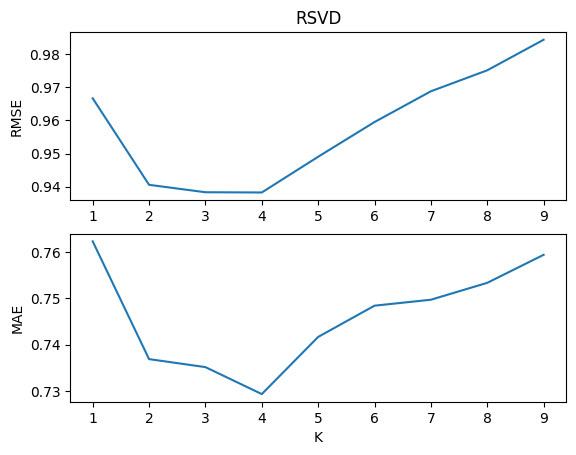

In [8]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmseArr)
ax[0].set_title("RSVD")
ax[0].set_ylabel("RMSE")
ax[1].plot(k_range, maeArr)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")

plt.show()

In [9]:
globalMean = np.mean(ratings_tuples, axis=0)[2]
predicted_global = [globalMean for _ in range(len(y))]


rmse_global = math.sqrt(np.mean((predicted_global - y) ** 2))
rmse_global_arr = [rmse_global for _ in range(len(rmseArr))]

mae_global = np.mean(np.abs(predicted_global - y))
mae_global_arr = [mae_global for _ in range(len(maeArr))]

Para comparar os resultados obtidos, criamos um modelo que sempre avalia a nota como a média global. É possível ver que o RSVD ficou com um desempenho bem melhor.

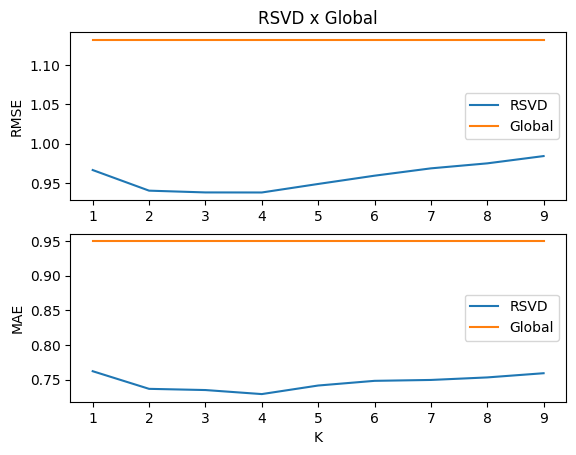

In [11]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmseArr)
ax[0].set_title("RSVD x Global")
ax[0].set_ylabel("RMSE")
ax[0].plot(k_range, rmse_global_arr)
ax[0].legend(["RSVD", "Global"])
ax[1].plot(k_range, maeArr)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")
ax[1].plot(k_range, mae_global_arr)
ax[1].legend(["RSVD", "Global"])

plt.show()